# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups), and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](./quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e., it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([1, 0, 1, ..., 0, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.868315,0.848743
Balanced Accuracy,0.797330,0.768163
F1 score,0.706140,0.660040
MCC,0.624184,0.566166
Precision,0.757647,0.714058
Recall,0.661191,0.613621
ROC AUC,0.925353,0.821574


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.192654,0.013454
Predictive Parity,0.023061,0.363074
Equal Opportunity,0.107284,0.265979
Average Group Difference in False Negative Rate,0.107284,0.265979
Equalized Odds,0.091696,0.166141
Conditional Use Accuracy,0.053394,0.252662
Average Group Difference in Accuracy,0.100167,0.042973
Treatment Equality,0.303553,5.708978


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.868315           0.797330  0.706140  0.624184   
         0                   0.935277           0.775085  0.657963  0.632329   
         1                   0.835110           0.790672  0.713982  0.600346   
         Maximum difference  0.100167           0.015587  0.056019  0.031983   
updated  Overall             0.848743           0.768163  0.660040  0.566166   
         0                   0.877470           0.860754  0.599354  0.566152   
         1                   0.834497           0.760915  0.677950  0.589114   
         Maximum difference  0.042973           0.099839  0.078596  0.022962   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.757647  0.661191  0.925353          2922.0   
         0                    0.777778  0.570136  0.941812           442.0   
         1                    0.754717  0.677419  0.907388          2480.0   
         Maximum difference   0.023061  0.107284  0.034423          2038.0   
updated  Overall              0.714058  0.613621  0.821574          2922.0   
         0                    0.466080  0.839367  0.941812           442.0   
         1                    0.829155  0.573387  0.907388          2480.0   
         Maximum difference   0.363074  0.265979  0.034423          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.208828  
         0                                   0.080040  
         1                                   0.272694  
         Maximum difference                  0.192654  
updated  Overall                             0.205634  
         0                                   0.196640  
         1                                   0.210094  
         Maximum difference                  0.013454

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.103547,0.049493
Predictive Parity,0.074152,0.184299
Equal Opportunity,0.210605,0.209524
Average Group Difference in False Negative Rate,0.210605,0.209524
Equalized Odds,0.124660,0.119844
Conditional Use Accuracy,0.060003,0.128876
Average Group Difference in Accuracy,0.057328,0.040328
Treatment Equality,0.284902,2.099200


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.093956,0.019959
Predictive Parity,0.191814,0.133510
Equal Opportunity,0.145525,0.191602
Average Group Difference in False Negative Rate,0.145525,0.191602
Equalized Odds,0.093755,0.107181
Conditional Use Accuracy,0.115694,0.104046
Average Group Difference in Accuracy,0.054694,0.047595
Treatment Equality,0.292782,2.399059


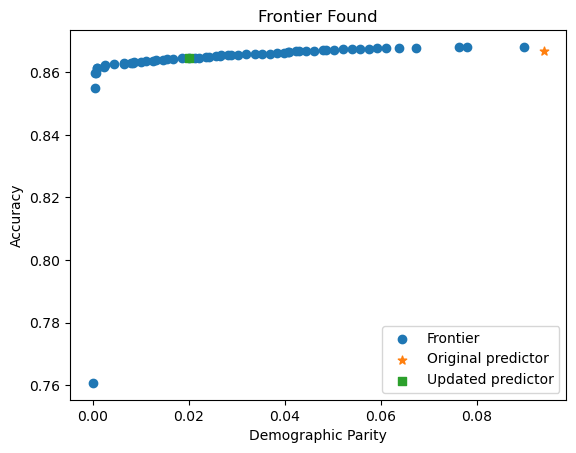

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

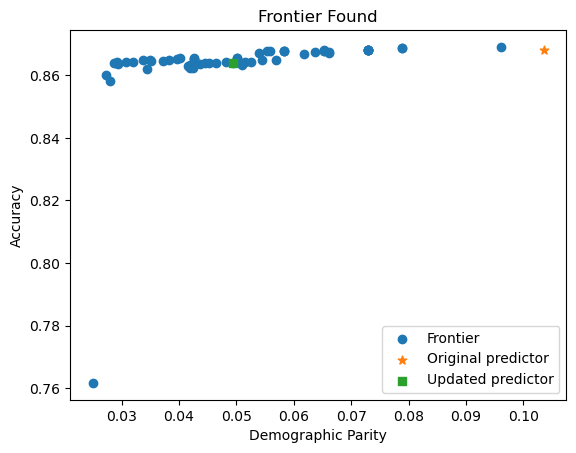

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.867988           0.795825  0.704437  0.622647   
         0                   0.892308           0.589364  0.300000  0.340009   
         1                   0.831978           0.754766  0.655556  0.553843   
         2                   0.929614           0.767418  0.658333  0.635246   
         3                   0.941176           0.815747  0.750000  0.730769   
         4                   0.861369           0.797787  0.709820  0.621215   
         Maximum difference  0.109198           0.226383  0.450000  0.390761   
updated  Overall             0.864057           0.769549  0.674382  0.601041   
         0                   0.869231           0.683662  0.451613  0.377718   
         1                   0.826558           0.726356  0.614458  0.529854   
         2                   0.915880           0.828757  0.675497  0.628493   
         3                   0.882353           0.871753  0.666667  0.622062   
         4                   0.859359           0.768508  0.678063  0.603743   
         Maximum difference  0.089322           0.188091  0.226450  0.250775   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.758689  0.657426  0.923695          2922.0   
         0                    0.750000  0.187500  0.877741            16.0   
         1                    0.746835  0.584158  0.908711           101.0   
         2                    0.814433  0.552448  0.947019           143.0   
         3                    0.900000  0.642857  0.956169            14.0   
         4                    0.756191  0.668807  0.921111          2648.0   
         Maximum difference   0.153165  0.481307  0.078428          2634.0   
updated  Overall              0.789982  0.588296  0.900496          2922.0   
         0                    0.466667  0.437500  0.877741            16.0   
         1                    0.784615  0.504950  0.908711           101.0   
         2                    0.641509  0.713287  0.947019           143.0   
         3                    0.545455  0.857143  0.956169            14.0   
         4                    0.807833  0.584215  0.921111          2648.0   
         Maximum difference   0.341166  0.419643  0.078428          2634.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                            114.0             0.123077   
         1                            268.0             0.273713   
         2                           1022.0             0.122747   
         3                             88.0             0.137255   
         4                           7797.0             0.253518   
         Maximum difference          7709.0             0.150966   
updated  Overall                     9289.0             0.239292   
         0                            114.0             0.123077   
         1                            268.0             0.273713   
         2                           1022.0             0.122747   
         3                             88.0             0.137255   
         4                           7797.0             0.253518   
         Maximum difference          7709.0             0.150966   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.207354  
         0                                   0.030769  
         1                                   0.214092  
         2                                   0.083262  
         3                                   0.098039  
         4        

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.866749           0.790909  0.698648  0.617308   
         0                   0.883929           0.658163  0.434783  0.384833   
         1                   0.836412           0.756772  0.651685  0.551016   
         2                   0.931217           0.751402  0.628571  0.608799   
         3                   0.937500           0.730769  0.631579  0.656551   
         4                   0.859926           0.792788  0.704770  0.616571   
         Maximum difference  0.101088           0.134625  0.269987  0.271718   
updated  Overall             0.864537           0.770221  0.675559  0.602537   
         0                   0.910714           0.887755  0.705882  0.669662   
         1                   0.828496           0.724853  0.606061  0.516155   
         2                   0.921517           0.845714  0.681004  0.640009   
         3                   0.901786           0.877622  0.666667  0.631638   
         4                   0.858780           0.767751  0.677567  0.603533   
         Maximum difference  0.093021           0.162902  0.099822  0.153507   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.761405  0.645448  0.920445          2922.0   
         0                    0.555556  0.357143  0.948251            14.0   
         1                    0.725000  0.591837  0.893093            98.0   
         2                    0.795181  0.519685  0.953139           127.0   
         3                    1.000000  0.461538  0.963481            13.0   
         4                    0.761635  0.655805  0.916189          2670.0   
         Maximum difference   0.444444  0.298662  0.070388          2657.0   
updated  Overall              0.791360  0.589322  0.894418          2922.0   
         0                    0.600000  0.857143  0.948251            14.0   
         1                    0.746269  0.510204  0.893093            98.0   
         2                    0.625000  0.748031  0.953139           127.0   
         3                    0.550000  0.846154  0.963481            13.0   
         4                    0.810642  0.582022  0.916189          2670.0   
         Maximum difference   0.260642  0.346939  0.070388          2657.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                             98.0             0.125000   
         1                            281.0             0.258575   
         2                           1007.0             0.111993   
         3                             99.0             0.116071   
         4                           7803.0             0.254941   
         Maximum difference          7705.0             0.146582   
updated  Overall                     9288.0             0.239312   
         0                             98.0             0.125000   
         1                            281.0             0.258575   
         2                           1007.0             0.111993   
         3                             99.0             0.116071   
         4                           7803.0             0.254941   
         Maximum difference          7705.0             0.146582   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.202867  
         0                                   0.080357  
         1                                   0.211082  
         2                                   0.073192  
         3                                   0.053571  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.134287,0.016033,0.657983,0.650000
Disparate Impact,0.706830,0.981370,0.657983,0.647479
Average Group Difference in Conditional Acceptance Rate,0.197906,0.008440,0.657983,0.655462
Average Group Difference in Conditional Rejectance Rate,0.046598,0.016439,0.657983,0.655462
Average Group Difference in Accuracy,0.015688,0.021157,0.657983,0.654622
Average Group Difference in Recall,0.141640,0.058647,0.657983,0.652101
Average Group Difference in Acceptance Rate,0.087016,0.076756,0.657983,0.660504
Average Group Difference in Specificity,0.091102,0.053444,0.657983,0.658824
Average Group Difference in Rejection Rate,0.052209,0.035084,0.657983,0.660924
Treatment Equality,0.185564,0.055206,0.657983,0.655462


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.153068,0.102293,0.663866,0.621429
Disparate Impact,0.697450,0.686713,0.663866,0.611765
Average Group Difference in Conditional Acceptance Rate,0.266809,0.155159,0.663866,0.647059
Average Group Difference in Conditional Rejectance Rate,0.098374,0.038179,0.663866,0.661765
Average Group Difference in Accuracy,0.005545,0.019626,0.663866,0.661345
Average Group Difference in Recall,0.157070,0.118976,0.663866,0.628571
Average Group Difference in Acceptance Rate,0.078017,0.084274,0.663866,0.657983
Average Group Difference in Specificity,0.107762,0.089286,0.663866,0.649160
Average Group Difference in Rejection Rate,0.043247,0.041363,0.663866,0.660504
Treatment Equality,0.318437,0.143180,0.663866,0.646639


In [23]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.663866           0.655245  0.603568  0.315750   
         African-American    0.661198           0.661083  0.668805  0.322081   
         Caucasian           0.665432           0.624102  0.502752  0.270386   
         Other               0.669516           0.618321  0.486726  0.252697   
         Maximum difference  0.008318           0.042762  0.182079  0.069384   
updated  Overall             0.646639           0.629716  0.538673  0.277867   
         African-American    0.639869           0.642660  0.609083  0.290279   
         Caucasian           0.644444           0.590868  0.428571  0.211519   
         Other               0.675214           0.598917  0.418367  0.239210   
         Maximum difference  0.035345           0.051792  0.190715  0.078760   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.644444  0.567568  0.705639          1073.0   
         African-American     0.672581  0.665072  0.704855           627.0   
         Caucasian            0.606195  0.429467  0.683915           319.0   
         Other                0.555556  0.433071  0.703881           127.0   
         Maximum difference   0.117025  0.235605  0.020940           500.0   
updated  Overall              0.654667  0.457596  0.692327          1073.0   
         African-American     0.689516  0.545455  0.690321           627.0   
         Caucasian            0.583784  0.338558  0.667708           319.0   
         Other                0.594203  0.322835  0.705884           127.0   
         Maximum difference   0.105732  0.222620  0.038176           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.397059  
         African-American                    0.508614  
         Caucasian                           0.279012  
         Other                               0.282051  
         Maximum difference                  0.229601  
updated  Overall                             0.315126  
         African-American                    0.406891  
         Caucasian                           0.228395  
         Other                               0.196581  
         Maximum difference                  0.210310

In [24]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [25]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.736455,0.681856
Average Group Difference in Conditional Positive Prediction Rate,0.136081,0.019586


In [26]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.663866,0.619328
Average Group Difference in Conditional Positive Prediction Rate,0.151770,0.111426
